In [52]:
import pandas as pd
import numpy as np
import os
import math
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_excel("initial_data/nipt_data.xlsx")
print(df.head())

   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00  自然受孕  20230429       1   
1   2  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230531       2   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00  自然受孕  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00  自然受孕  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00  自然受孕  20240219       1   

    检测孕周  ...    Y染色体浓度    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  \
0  11w+6  ...  0.025936  0.038061     0.377069     0.389803     0.399399   
1  15w+6  ...  0.034887  0.059572     0.371542     0.384771     0.391706   
2  20w+1  ...  0.066171  0.075995     0.377449     0.390582     0.399480   
3  22w+6  ...  0.061192  0.052305     0.375613     0.389251     0.397212   
4  13w+6  ...  0.059230  0.059708     0.380260     0.393618     0.404868   

   被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次数  胎儿是否健康  
0    0.027484       NaN     1     

In [53]:
BMI_info=df['孕妇BMI']
df['Y染色体浓度']=np.log(df['Y染色体浓度']/(1-df['Y染色体浓度']))

def convert_ga_to_decimal(ga_str):
    """将“Xw+Y”格式转换为小数周（如11w+6 = 11 + 6/7 ≈ 11.86周）"""
    if pd.isna(ga_str):
        return np.nan
    if 'w+' in str(ga_str):
        w_part, d_part = str(ga_str).split('w+')
    else:
        return np.nan
    try:
        return int(w_part) + int(d_part) / 7
    except (ValueError, IndexError):
        return np.nan
    

df['小数孕周'] = df['检测孕周'].apply(convert_ga_to_decimal)
df = df[(df['小数孕周'] >= 10) & (df['小数孕周'] <= 25)]

gestational_weeks_info=df['小数孕周']

In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#拟合模型
model = smf.mixedlm(
    "Y染色体浓度 ~ 孕妇BMI + 小数孕周",
    df,
    groups=df["孕妇代码"]
)
result1 = model.fit()

# 打印结果汇总
print(result1.summary())

#算R²
actual = df["Y染色体浓度"]
predictions = result1.fittedvalues
r_squared1 = r2_score(actual, predictions)
print("Marginal R²:", r_squared1)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

random_effects_variance = result1.cov_re
print("随机效应方差（组间方差）:")
print(random_effects_variance)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y染色体浓度   
No. Observations: 940     Method:             REML     
No. Groups:       260     Scale:              0.0657   
Min. group size:  1       Log-Likelihood:     -381.7093
Max. group size:  8       Converged:          Yes      
Mean group size:  3.6                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   -2.717    0.269 -10.090 0.000 -3.245 -2.189
孕妇BMI       -0.019    0.009  -2.243 0.025 -0.036 -0.002
小数孕周         0.046    0.003  16.223 0.000  0.040  0.051
Group Var    0.201    0.091                            

Marginal R²: 0.8069523848167698
RMSE: 0.22170939257872677
随机效应方差（组间方差）:
          Group
Group  0.200669


In [55]:
model = smf.mixedlm(
    formula="Y染色体浓度 ~ 孕妇BMI * 小数孕周",
    data=df,
    groups=df["孕妇代码"]
)
result2 = model.fit()
print(result2.summary())

#算R²
actual = df["Y染色体浓度"]
predictions = result2.fittedvalues
r_squared2 = r2_score(actual, predictions)
print("Marginal R²:", r_squared2)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Y染色体浓度   
No. Observations: 940     Method:             REML     
No. Groups:       260     Scale:              0.0656   
Min. group size:  1       Log-Likelihood:     -386.0219
Max. group size:  8       Converged:          Yes      
Mean group size:  3.6                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -1.767    0.560 -3.155 0.002 -2.865 -0.669
孕妇BMI        -0.049    0.017 -2.792 0.005 -0.083 -0.015
小数孕周         -0.006    0.027 -0.222 0.825 -0.059  0.047
孕妇BMI:小数孕周    0.002    0.001  1.934 0.053 -0.000  0.003
Group Var     0.200    0.091                           

Marginal R²: 0.8077105120499055
RMSE: 0.22127362113500382


In [56]:
model = smf.mixedlm(
    "Y染色体浓度 ~ 孕妇BMI + 小数孕周",  # 固定效应：交互项
    df,
    groups=df["孕妇代码"],                # 按孕妇代码分组（随机截距）
    re_formula="1 + 孕妇BMI + 小数孕周"  # 随机截距和随机斜率
)

result3 = model.fit()
print(result3.summary())

#算R²
actual = df["Y染色体浓度"]
predictions = result3.fittedvalues
r_squared3 = r2_score(actual, predictions)
print("Marginal R²:", r_squared3)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Y染色体浓度   
No. Observations:    940      Method:              REML     
No. Groups:          260      Scale:               0.0422   
Min. group size:     1        Log-Likelihood:      -708.9687
Max. group size:     8        Converged:           No       
Mean group size:     3.6                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         -4.381    0.572 -7.663 0.000 -5.502 -3.261
孕妇BMI              0.032    0.019  1.656 0.098 -0.006  0.070
小数孕周               0.047    0.004 11.478 0.000  0.039  0.055
Group Var          0.042    1.672                           
Group x 孕妇BMI Cov -0.002    0.108                           
孕妇BMI Var          0.005    0.006                           
Group x 小数孕周 Cov  -0.000    0.066   

In [57]:
model = smf.mixedlm(
    "Y染色体浓度 ~ 孕妇BMI * 小数孕周",  # 固定效应：交互项
    df,
    groups=df["孕妇代码"],                # 按孕妇代码分组（随机截距）
    re_formula="1 + 孕妇BMI + 小数孕周"  # 随机截距和随机斜率
)

result4 = model.fit()
print(result4.summary())

#算R²
actual = df["Y染色体浓度"]
predictions = result4.fittedvalues
r_squared4 = r2_score(actual, predictions)
print("Marginal R²:", r_squared4)
mse = mean_squared_error(actual, predictions)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\xia\anaconda3\envs\byd\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Y染色体浓度   
No. Observations:    940      Method:              REML     
No. Groups:          260      Scale:               0.0408   
Min. group size:     1        Log-Likelihood:      -745.7270
Max. group size:     8        Converged:           No       
Mean group size:     3.6                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         -3.223    0.660 -4.880 0.000 -4.518 -1.929
孕妇BMI             -0.003    0.022 -0.142 0.887 -0.046  0.040
小数孕周              -0.036    0.027 -1.312 0.190 -0.089  0.018
孕妇BMI:小数孕周         0.003    0.001  3.089 0.002  0.001  0.004
Group Var          0.041    2.198                           
Group x 孕妇BMI Cov -0.002    0.156                           
孕妇BMI Var          0.006    0.009   

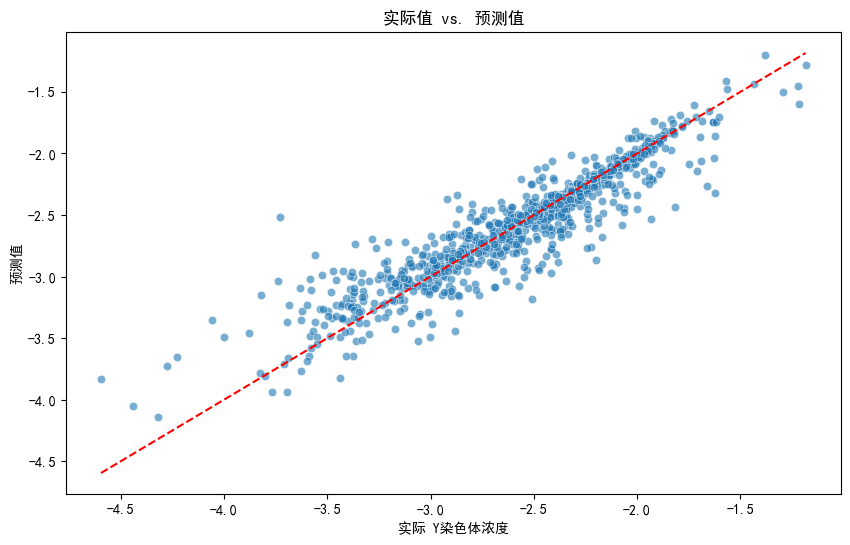

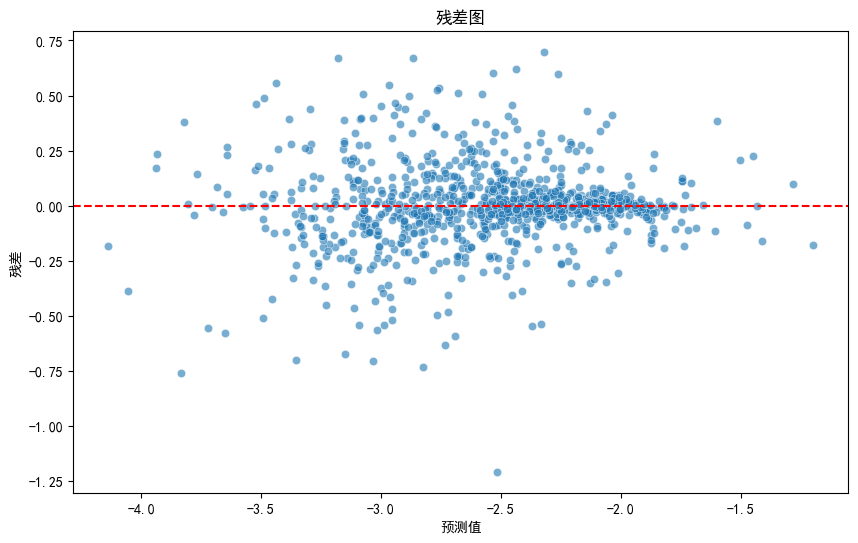

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df["预测值"] = result4.fittedvalues
df["残差"] = df["Y染色体浓度"] - df["预测值"]  # 残差 = 实际值 - 预测值

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Y染色体浓度", y="预测值", alpha=0.6)
plt.plot([df["Y染色体浓度"].min(), df["Y染色体浓度"].max()],
         [df["Y染色体浓度"].min(), df["Y染色体浓度"].max()],
         'r--')  # 45度对角线
plt.title("实际值 vs. 预测值")
plt.xlabel("实际 Y染色体浓度")
plt.ylabel("预测值")
plt.show()

# 可视化 2：残差图(图)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="预测值", y="残差", alpha=0.6)
plt.axhline(0, color='r', linestyle='--')  # 中心线
plt.title("残差图")
plt.xlabel("预测值")
plt.ylabel("残差")
plt.show()
